In [29]:
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

In [30]:
#from evaluate.evaluate_rt_model import evaluate_rt_model
#from model.predict import model_predict

In [31]:
experiments = pd.read_csv("../results/experiments.csv")
#experiments = pd.read_csv("../experiments.csv")

In [32]:
experiments

,RUN,modelname,data,num_units,num_blocks,epochs,batch_size,learningrate,optimizer,dropout,...,AE_1,AE_2,AE_3,AE_4,AE_5,TC_t_1,TC_t_2,TC_t_3,TC_t_4,TC_t_5
0,0,LSTM,sepsis,100,2,200,1024,0.10,NADAM,0.2,...,13.193420,12.971055,13.480948,13.424916,14.250611,0.0,0.401425,0.361498,0.223038,0.145159
1,1,LSTM,sepsis,100,2,200,1024,0.10,NADAM,0.2,...,13.542580,13.167601,13.613719,13.551432,14.365966,0.0,0.716537,0.181285,0.111100,0.073158
2,2,LSTM,sepsis,100,2,200,1024,0.10,NADAM,0.2,...,13.103835,12.987243,13.574849,13.606878,14.469911,0.0,0.514523,0.143945,0.103640,0.133015
3,3,LSTM,sepsis,100,2,200,1024,0.10,NADAM,0.2,...,13.301361,12.813811,13.344928,13.347926,14.265526,0.0,0.837860,0.386102,0.190290,0.142966
4,4,LSTM,sepsis,100,2,200,1024,0.10,NADAM,0.2,...,12.972703,13.001880,13.558743,13.583575,14.340341,0.0,0.755476,0.215686,0.177896,0.165955
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
155,155,LSTM,hospital_billing,100,2,200,128,0.01,NADAM,0.2,...,67.993587,44.346182,41.978316,39.119387,42.381532,0.0,1.834878,2.109112,1.580696,2.433303
156,156,LSTM,hospital_billing,100,2,200,128,0.01,NADAM,0.2,...,70.469499,44.973510,41.908268,39.532631,42.002239,0.0,1.708861,1.013340,2.086441,2.173564
157,157,LSTM,hospital_billing,100,2,200,128,0.01,NADAM,0.2,...,69.835864,45.143645,41.554904,39.034665,42.082421,0.0,1.370082,1.373548,1.908190,2.323803
158,158,LSTM,hospital_billing,100,2,200,128,0.01,NADAM,0.2,...,69.052659,44.989154,41.387211,38.958338,42.693385,0.0,1.951126,1.625852,2.052640,4.442858


In [33]:
experiments.columns

Index(['RUN', 'modelname', 'data', 'num_units', 'num_blocks', 'epochs',
       'batch_size', 'learningrate', 'optimizer', 'dropout', 'early_stop',
       'lr_reduce', 'sgd_momentum', 'loss_function', 'alpha', 'beta', 'gamma',
       'n_estimators', 'max_depth', 'eta', 'subsample', 'colsample_bytree',
       'y_transformation', 'sim_save_eventlog', 'sim_statespace_size',
       'sim_number_of_traces', 'sim_process_entropy', 'sim_process_type',
       'sim_process_memory', 'sim_med_ent_e_steps',
       'sim_med_ent_n_transitions', 'sim_med_ent_max_trials',
       'sim_inter_arrival_time', 'sim_process_stability_scale',
       'sim_resource_availability_p', 'sim_resource_availability_n',
       'sim_resource_availability_m', 'sim_activity_duration_lambda_range',
       'sim_deterministic_offset_W', 'Deterministic_offset_u',
       'data_inference_tables', 'data_last_state', 'data_n_traces',
       'data_max_prefix_length', 'data_min_prefix_length', 'data_split_mode',
       'data_train_ra

# Target versus prediction: Train

In [30]:
selected_runs = [65, 162, 209, 376]

In [31]:
inference_list = []

for i in selected_runs:
    #Load data objects to get the inference table
    file = "experiment_"+str(i)
    with open('../results/'+file+'.pickle', 'rb') as handle:
        data_objects = pickle.load(handle)
    print(file)
    
    # get inference table for MAE calculation
    inftable = data_objects["inference_train"]
        
    #Crosstab 
    prediction = pd.pivot_table(inftable, 
                                    values="y_pred",
                                    columns=['prefix_number'], 
                                    aggfunc=np.mean).T
    prediction["metric"] = "y_pred"
    prediction["y_pred"] = prediction["y_pred"]/(24.0*3600) #convert to days
    prediction = prediction.rename(columns={"y_pred":"value"})
    prediction = prediction.reset_index()
    
    #Crosstab 
    target = pd.pivot_table(inftable, 
                                    values="y",
                                    columns=['prefix_number'], 
                                    aggfunc=np.mean).T
    
    target["metric"] = "y"
    target["y"] = target["y"]/(24.0*3600) #convert to days
    target = target.rename(columns={"y":"value"})
    target = target.reset_index()
    
      
    
    pivottable = pd.concat([prediction,target],axis=0)
        
    #mark with needed information
    pivottable["data"] = data_objects['curr_settings']["data"]
    pivottable["loss_function"] = data_objects['curr_settings']["loss_function"]
    
        
    inference_list.append(pivottable)
    #print(len(inference_list))

#generate a df
inference_list = pd.concat(inference_list)
inference_list = inference_list.reset_index()


experiment_65
experiment_162
experiment_209
experiment_376


In [32]:
inference_list

,index,prefix_number,value,metric,data,loss_function
0,0,1,2.511815,y_pred,sepsis,MAE
1,1,2,3.335414,y_pred,sepsis,MAE
2,2,3,3.428678,y_pred,sepsis,MAE
3,3,4,3.418556,y_pred,sepsis,MAE
4,4,5,3.624932,y_pred,sepsis,MAE
...,...,...,...,...,...,...
131,14,15,22.413337,y,hospital_billing,MAE
132,15,16,20.987791,y,hospital_billing,MAE
133,16,17,16.208627,y,hospital_billing,MAE
134,17,18,12.180010,y,hospital_billing,MAE


In [33]:
# get a copy of all values
inference_list["loss_prediction"] = inference_list["metric"]

#overwrite when the row value of new column is not = "y"
inference_list.loc[(inference_list["loss_prediction"] != "y"), "loss_prediction"] = inference_list.loc[(inference_list["loss_prediction"] != "y"), "loss_function"]


# New models

C:\Users\Mike\AppData\Local\Temp\ipykernel_31232\461378211.py:77: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


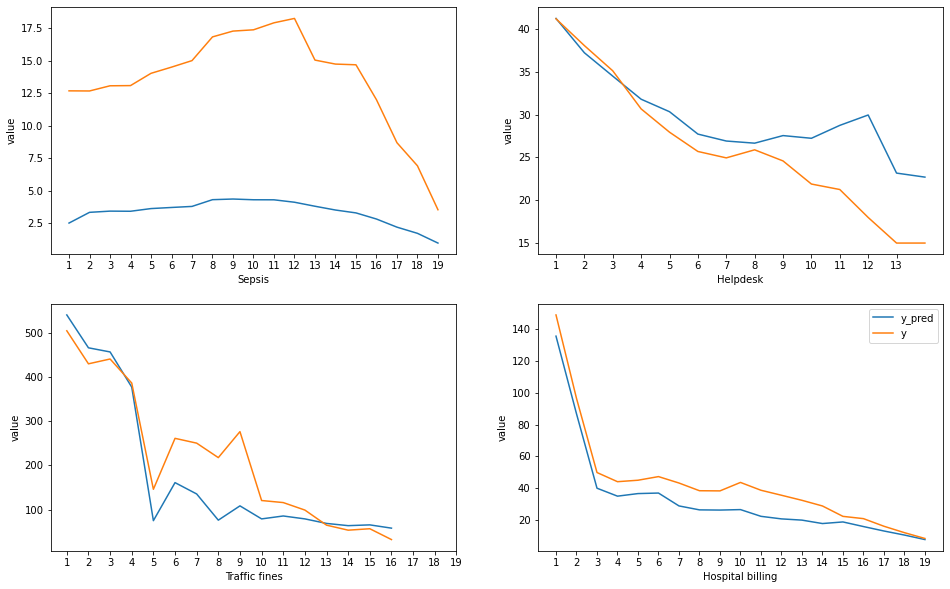

In [34]:
fig, ax = plt.subplots(2,2, figsize=(16, 10))
#fig, ax = plt.subplots(2,2, figsize=(20, 14))
from  matplotlib.ticker import FuncFormatter

metric = "value"
xaxis = "prefix_number"
hue = "metric"

hue_order = ['y', 'y_pred']

fliersize = 1
width = 0.8

# Exclude some results
sepsis = inference_list.loc[inference_list.data == "sepsis"]

# “ci”, “pi”, “se”, or “sd”

sns.lineplot(x=sepsis[xaxis], 
            y=sepsis[metric],
             ci='sd',
            hue=sepsis[hue],
            ax=ax[0,0])



helpdesk = inference_list.loc[inference_list.data == "helpdesk"]

sns.lineplot(x=helpdesk[xaxis], 
            y=helpdesk[metric],
             ci='sd',
            hue=helpdesk[hue],
            ax=ax[0,1])


traffic_fines = inference_list.loc[inference_list.data == "traffic_fines"]

sns.lineplot(x=traffic_fines[xaxis], 
            y=traffic_fines[metric],
             ci='sd',
            hue=traffic_fines[hue],
            ax=ax[1,0])

hospital_billing = inference_list.loc[inference_list.data == "hospital_billing"]

sns.lineplot(x=hospital_billing[xaxis], 
            y=hospital_billing[metric],
            hue=hospital_billing[hue],
             ci='sd',
            ax=ax[1,1])


ax[0,0].set(xlabel='Sepsis', ylabel=metric)#, xlim=[1,19])
ax[0,0].xaxis.set_major_formatter(FuncFormatter(lambda x, _: int(x)))
ax[0,0].set_xticks(range(1,20))
ax[0,0].legend([],[], frameon=False)

ax[0,1].set(xlabel='Helpdesk', ylabel=metric)#, xlim=[-0.5,6])
ax[0,1].xaxis.set_major_formatter(FuncFormatter(lambda x, _: int(x)))
ax[0,1].set_xticks(range(1,14))
ax[0,1].legend([],[], frameon=False)

ax[1,0].set(xlabel='Traffic fines', ylabel=metric)#, xlim=[-0.5,6])
ax[1,0].xaxis.set_major_formatter(FuncFormatter(lambda x, _: int(x)))
ax[1,0].set_xticks(range(1,20))
ax[1,0].legend([],[], frameon=False)

ax[1,1].set(xlabel='Hospital billing', ylabel=metric)#, xlim=[-0.5,6])
ax[1,1].xaxis.set_major_formatter(FuncFormatter(lambda x, _: int(x)))
ax[1,1].set_xticks(range(1,20))
ax[1,1].legend(loc='upper right')


#plt.gca().xaxis.set_major_formatter(FuncFormatter(lambda x, _: int(x)))

plt.savefig("predictions_train.png", dpi=200, bbox_inches = "tight")
fig.show()

# All models

In [34]:
inference_list = []

for i in experiments.RUN:
    #Load data objects to get the inference table
    file = "experiment_"+str(i)
    with open('../results/'+file+'.pickle', 'rb') as handle:
        data_objects = pickle.load(handle)
    print(file)
    
    # get inference table for MAE calculation
    inftable = data_objects["inference_test"]
        
    #Crosstab 
    prediction = pd.pivot_table(inftable, 
                                    values="y_pred",
                                    columns=['prefix_number'], 
                                    aggfunc=np.mean).T
    prediction["metric"] = "y_pred"
    prediction["y_pred"] = prediction["y_pred"]/(24.0*3600) #convert to days
    prediction = prediction.rename(columns={"y_pred":"value"})
    prediction = prediction.reset_index()
    
    #Crosstab 
    target = pd.pivot_table(inftable, 
                                    values="y",
                                    columns=['prefix_number'], 
                                    aggfunc=np.mean).T
    
    target["metric"] = "y"
    target["y"] = target["y"]/(24.0*3600) #convert to days
    target = target.rename(columns={"y":"value"})
    target = target.reset_index()
    
      
    
    pivottable = pd.concat([prediction,target],axis=0)
        
    #mark with needed information
    pivottable["data"] = data_objects['curr_settings']["data"]
    pivottable["loss_function"] = data_objects['curr_settings']["loss_function"]
    
        
    inference_list.append(pivottable)
    #print(len(inference_list))

#generate a df
inference_list = pd.concat(inference_list)
inference_list = inference_list.reset_index()


experiment_0
experiment_1
experiment_2
experiment_3
experiment_4
experiment_5
experiment_6
experiment_7
experiment_8
experiment_9
experiment_10
experiment_11
experiment_12
experiment_13
experiment_14
experiment_15
experiment_16
experiment_17
experiment_18
experiment_19
experiment_20
experiment_21
experiment_22
experiment_23
experiment_24
experiment_25
experiment_26
experiment_27
experiment_28
experiment_29
experiment_30
experiment_31
experiment_32
experiment_33
experiment_34
experiment_35
experiment_36
experiment_37
experiment_38
experiment_39
experiment_40
experiment_41
experiment_42
experiment_43
experiment_44
experiment_45
experiment_46
experiment_47
experiment_48
experiment_49
experiment_50
experiment_51
experiment_52
experiment_53
experiment_54
experiment_55
experiment_56
experiment_57
experiment_58
experiment_59
experiment_60
experiment_61
experiment_62
experiment_63
experiment_64
experiment_65
experiment_66
experiment_67
experiment_68
experiment_69
experiment_70
experiment_71
ex

In [35]:
# get a copy of all values
inference_list["loss_prediction"] = inference_list["metric"]

#overwrite when the row value of new column is not = "y"
inference_list.loc[(inference_list["loss_prediction"] != "y"), "loss_prediction"] = inference_list.loc[(inference_list["loss_prediction"] != "y"), "loss_function"]


In [36]:
inference_list["loss_prediction"].value_counts()

y          2800
MAE         700
MAE_Mtd     700
MAE_Ptd     700
MAE_Etd     700
Name: loss_prediction, dtype: int64

C:\Users\Mike\AppData\Local\Temp\ipykernel_31856\2811228633.py:62: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


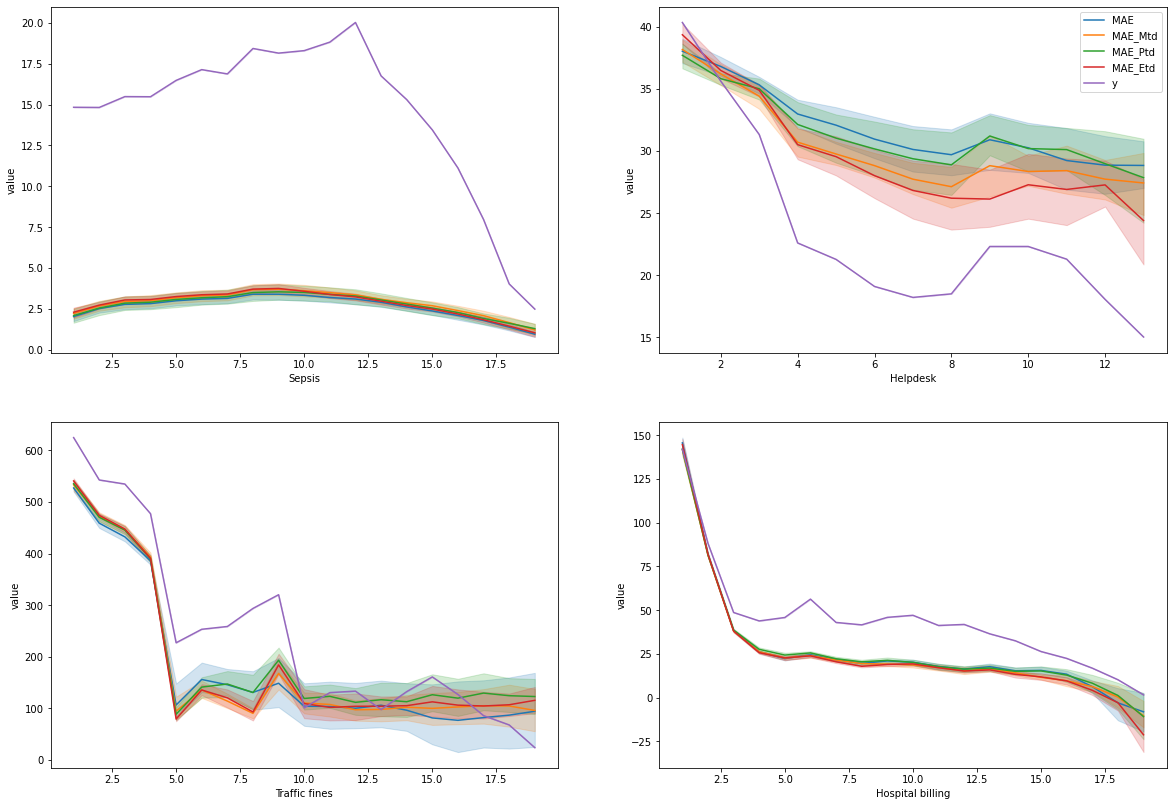

In [38]:
#fig, ax = plt.subplots(2,2, figsize=(16, 10))
fig, ax = plt.subplots(2,2, figsize=(20, 14))

metric = "value"
xaxis = "prefix_number"
hue = "loss_prediction"

hue_order = ['MAE', 'MAE_Mtd', 'MAE_Ptd','MAE_Etd', "y"]

fliersize = 1
width = 0.8

# Exclude some results
sepsis = inference_list.loc[inference_list.data == "sepsis"]

sns.lineplot(x=sepsis[xaxis], 
            y=sepsis[metric],
            hue=sepsis[hue],
            hue_order = hue_order,
            ax=ax[0,0])



helpdesk = inference_list.loc[inference_list.data == "helpdesk"]

sns.lineplot(x=helpdesk[xaxis], 
            y=helpdesk[metric],
            hue=helpdesk[hue],
            hue_order = hue_order,
            ax=ax[0,1])


traffic_fines = inference_list.loc[inference_list.data == "traffic_fines"]

sns.lineplot(x=traffic_fines[xaxis], 
            y=traffic_fines[metric],
            hue=traffic_fines[hue],
            hue_order = hue_order,
            ax=ax[1,0])

hospital_billing = inference_list.loc[inference_list.data == "hospital_billing"]

sns.lineplot(x=hospital_billing[xaxis], 
            y=hospital_billing[metric],
            hue=hospital_billing[hue],
            hue_order = hue_order,
            ax=ax[1,1])


ax[0,0].set(xlabel='Sepsis', ylabel=metric)#, xlim=[-0.5,6])
ax[0,0].legend([],[], frameon=False)
ax[0,1].set(xlabel='Helpdesk', ylabel=metric)#, xlim=[-0.5,6])
ax[0,1].legend(loc='upper right')
ax[1,0].set(xlabel='Traffic fines', ylabel=metric)#, xlim=[-0.5,6])
ax[1,0].legend([],[], frameon=False)
ax[1,1].set(xlabel='Hospital billing', ylabel=metric)#, xlim=[-0.5,6])
ax[1,1].legend([],[], frameon=False)


plt.savefig("predictions_all_test.png", dpi=300, bbox_inches = "tight")

fig.show()